In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/comment_toxicity/train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

In [7]:
#data preprocessing
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values #converts into numpy array

In [9]:
MAX_FEATURES = 190000  #number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES, output_sequence_length=1800,output_mode = 'int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
#MCSHBAP
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset= dataset.prefetch(8)

In [15]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [16]:
int(len(dataset)*.7)

6981

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [18]:
train_generator = train.as_numpy_iterator()

In [19]:
train_generator.next()

(array([[ 1256,   850,   655, ...,     0,     0,     0],
        [  287,    84,   846, ...,     0,     0,     0],
        [  115,   547,    18, ...,     0,     0,     0],
        ...,
        [  265,   441,     8, ...,     0,     0,     0],
        [34070,   945,   883, ...,     0,     0,     0],
        [  288, 22579,   288, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
#create the embedding layer
model.add(Embedding(MAX_FEATURES+1,32))
#Create the LSTM layer
model.add(Bidirectional(LSTM(32,activation='tanh')))
#feature activation Fully connected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
#final layer
model.add(Dense(6,activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy',optimizer = 'Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6080032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [24]:
history = model.fit(train,epochs=2,validation_data = val)

Epoch 1/2
6981/6981 [==============================] - 9919s 1s/step - loss: 0.0632 - val_loss: 0.0443
Epoch 2/2
6981/6981 [==============================] - 9866s 1s/step - loss: 0.0457 - val_loss: 0.0427


In [25]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

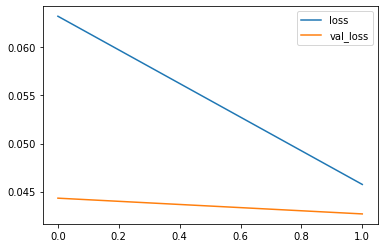

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
#Make Predictions
input_text = vectorizer("You are disgusting!")

In [28]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [29]:
batch = test.as_numpy_iterator().next()

In [30]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [31]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [32]:
res =model.predict(batch_X)

In [33]:
res.flatten()

array([1.64481048e-06, 7.48174011e-17, 3.23113731e-08, 2.35096994e-11,
       7.87911780e-09, 1.21207577e-09, 1.36097938e-01, 2.03162432e-04,
       1.08574629e-02, 3.13887000e-03, 2.07452178e-02, 4.66981530e-03,
       1.16269934e-04, 6.21083567e-12, 6.08003029e-06, 4.64417482e-08,
       2.64973960e-06, 6.52299775e-07, 9.89684820e-01, 3.11255753e-02,
       9.79369879e-01, 2.46208906e-03, 5.27876019e-01, 1.90256536e-02,
       9.89228487e-04, 1.27616506e-09, 4.80279487e-05, 1.40698296e-06,
       3.43447864e-05, 9.15323471e-06, 1.47402287e-04, 1.05292398e-11,
       6.53385950e-06, 6.32835935e-08, 3.15183047e-06, 7.80662617e-07,
       1.60396099e-04, 1.07677140e-11, 5.55971792e-06, 6.03474035e-08,
       2.99220642e-06, 6.99704060e-07, 2.74866819e-04, 4.54882035e-11,
       1.06237921e-05, 1.56574785e-07, 6.17421620e-06, 1.52486712e-06,
       1.70379877e-04, 1.56459967e-11, 8.09955509e-06, 8.39750953e-08,
       3.93984101e-06, 9.98018209e-07, 2.03578711e-05, 5.27327476e-14,
      

In [34]:
#Evaluation
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
  #unpack the batch
  X_true, y_true = batch

  #Make prediction
  yhat = model.predict(X_true)

  #Flatten the predictions
  y_true = y_true.flatten()
  yhat= yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

In [37]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8634315133094788, Recall:0.7005062103271484, Accuracy:0.498495489358902


In [38]:
#Testing

!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 18.9 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 49.0 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 212 kB 60.0 MB/s 
     |████████████████████████████████| 270 kB 62.5 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 47.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 68 kB 6.8 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 594 kB 52.4 MB/s 
     |████████████████████████████████| 856 kB 47

In [39]:
import gradio as gr
import tensorflow as tf

In [40]:
model.save('toxicity.h5')

In [41]:
model = tf.keras.models.load_model('toxicity.h5')

In [42]:
input_str = vectorizer("Hey, you are the most disgusting, I hate you!")

In [43]:
res = model.predict(np.expand_dims(input_str,0))

In [44]:
res

array([[0.82388365, 0.00759554, 0.34450904, 0.01239648, 0.33993173,
        0.03518164]], dtype=float32)

In [45]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [46]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text= ' '
  for idx,col in enumerate(df.columns[2:-1]):
    text += '{}: {}\n'.format(col,results[0][idx]>0.5)

    return text

In [47]:
interface = gr.Interface(fn = score_comment, inputs = gr.inputs.Textbox(lines=2,placeholder='Comment to Score'),outputs = 'text')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [48]:
interface.launch(share = True, debug = False)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://23344.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f242ccadf90>,
 'http://127.0.0.1:7860/',
 'https://23344.gradio.app')